In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from numpy import linalg as ln #to compute eigen values/ vectors
import netCDF4 as nc

In [2]:
SST = nc.Dataset('sst.mon.ltm.1991-2020 (1).nc')#, 'r') # read or write mode?

In [3]:
SST

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: COBE Sea Surface Temperature Analysis
    history: Created 2022/12/30 by doMonthLTMNC4
    platform: Analyses
    original_source: http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_catalog?projectname=NEAR-GOOS
    Conventions: CF-1.2
    institution: NOAA ESRL/PSD
    comment: recent values (w/i last year) may change as dataset is updated. It is a monitoring dataset.
    dataset_title: COBE Sea Surface Temperature
    References: https://www.psl.noaa.gov/data/gridded/data.cobe.html
    not_missing_threshold_percent: minimum 3% values input to have non-missing output value
    dimensions(sizes): lon(360), lat(180), time(12), nbnds(2)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float64 climatology_bounds(time, nbnds), float32 sst(time, lat, lon), int16 valid_yr_count(time, lat, lon)
    groups: 

Goal: want [X'] (X prime matrix) of SST annomolies 

In [4]:
# read in the variables to reshape the data from 3D to a 2D array
sst = SST.variables['sst'][:]
lat = SST.variables['lat'][:]
lon = SST.variables['lon'][:]
time = SST.variables['time'][:]
SST.close() 

In [5]:
sst = sst.astype(np.float64)  # Convert SST to float64 precision
sst[np.isinf(sst)] = np.nan  # Ensure no infinities exist

In [11]:
# Compute monthly climatology
monthly_climatology = np.mean(sst, axis=0)  # Adjust for seasonal periodicity

sst_anomalies = sst - monthly_climatology

# Remove Long-Term Mean (Climatological Mean)
long_term_mean = np.mean(sst_anomalies, axis=0)  # Compute mean over time
sst_anomalies = sst_anomalies - long_term_mean  # Subtract long-term mean

In [20]:
# Code to compute monthly climatology that does not work (it makes sst = sst_anomalies)
#num_months = 12
#monthly_climatology = np.zeros((num_months, sst.shape[1], sst.shape[2]))

# Compute monthly climatology correctly
#for m in range(num_months):
#    monthly_climatology[m, :, :] = np.nanmean(sst[m::12, :, :], axis=0)  # Compute per month

# Now correctly subtract it to get anomalies
#sst_anomalies = np.zeros_like(sst)
#for t in range(sst.shape[0]):  # Loop over each time step
#    month_idx = t % 12  # Find corresponding month
#    sst_anomalies[t, :, :] = sst[t, :, :] - monthly_climatology[month_idx, :, :]

In [12]:
# Apply weights: optional, but this step doesn't exaderate poles/ high latitudes 
latitudes = np.deg2rad(lat)
weights = np.sqrt(np.cos(latitudes))[:, np.newaxis]
# Apply weights to anomalies
weighted_sst = sst_anomalies * weights


In [13]:
# Handle missing values: Replace NaNs with column mean (land and sea ice) can also replace with 2m air temperature 
nan_mask = np.isnan(weighted_sst)
weighted_sst[nan_mask] = np.nanmean(weighted_sst)

n_time, n_lat, n_lon = weighted_sst.shape
reshaped_data = weighted_sst.reshape(n_time, n_lat * n_lon)

Largest pattern: seasonality and climateology (need to remove this to see ENSO)
First calculate the climateology so you can remove it, or start with a dataset that only has annomolies (climateology is already removed)
Then remove long term mean. result is x2D weighted masked annomolies- this is what we need to for covariance matrix

In [14]:
# Compute EOFs
from sklearn.decomposition import PCA

# Apply PCA to the reshaped data
pca = PCA(n_components=10)  # Keep top 10 EOFs
pcs = pca.fit_transform(reshaped_data)  # Principal components
eofs = pca.components_  # EOFs
explained_variance = pca.explained_variance_ratio_  # Variance explained by each EOF

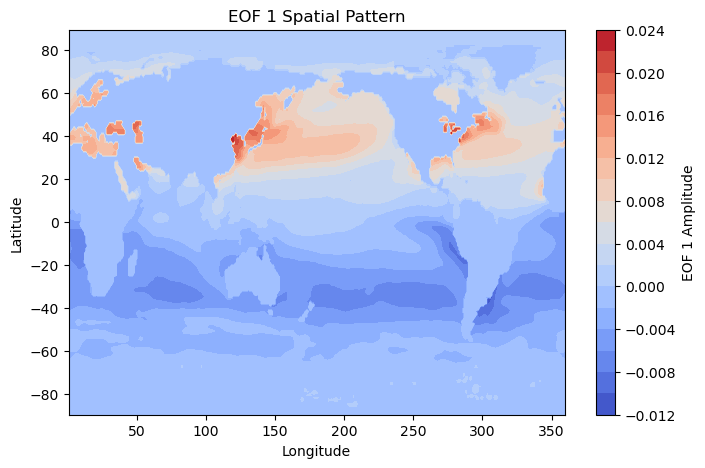

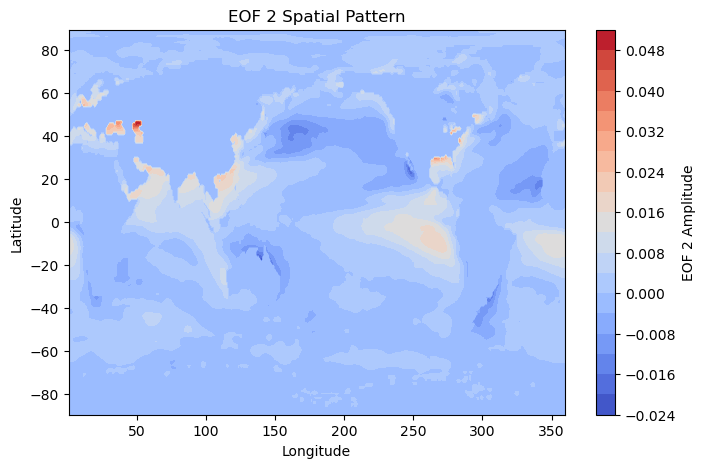

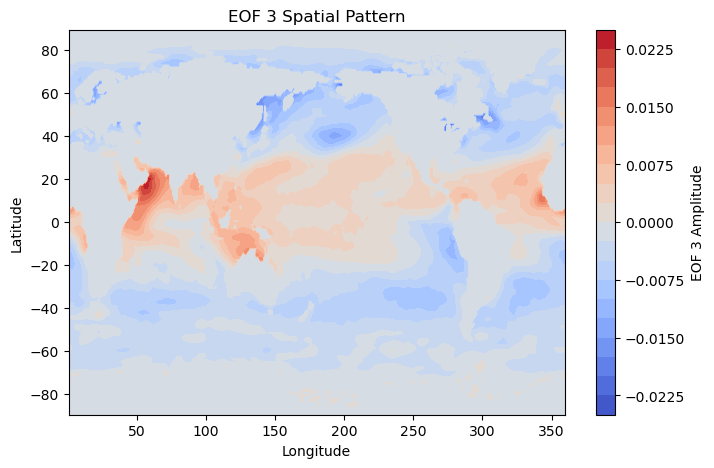

In [15]:

# Reshape EOFs back to spatial dimensions
eof1_map = eofs[0, :].reshape(sst.shape[1], sst.shape[2])
eof2_map = eofs[1, :].reshape(sst.shape[1], sst.shape[2])
eof3_map = eofs[2, :].reshape(sst.shape[1], sst.shape[2])

# Define a plotting function for cleaner code
def plot_eof(eof_map, eof_num):
    plt.figure(figsize=(8, 5))
    plt.contourf(lon, lat, eof_map, cmap="coolwarm", levels=20)
    plt.colorbar(label=f"EOF {eof_num} Amplitude")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"EOF {eof_num} Spatial Pattern")
    plt.show()

# Plot EOF 1, 2, and 3
plot_eof(eof1_map, 1)
plot_eof(eof2_map, 2)
plot_eof(eof3_map, 3)


More red means more of the variance is explained by the area- more red in the northern hemisphere and more blue in the southern hem. This means EOF 1 shows seasonal variability

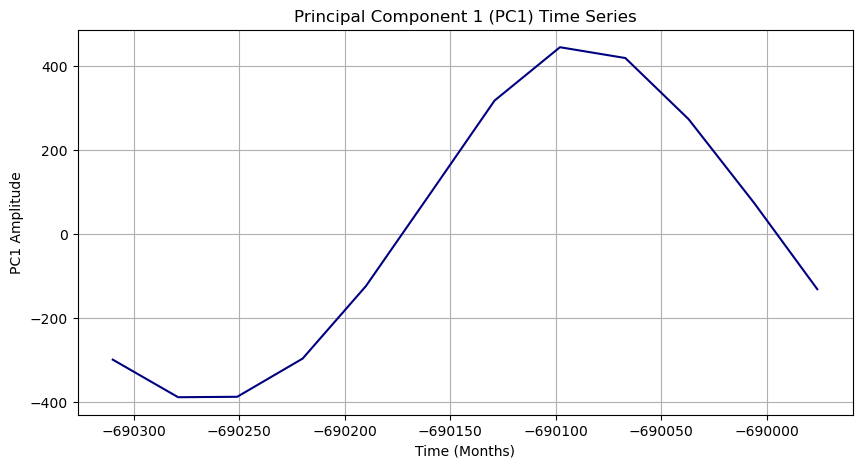

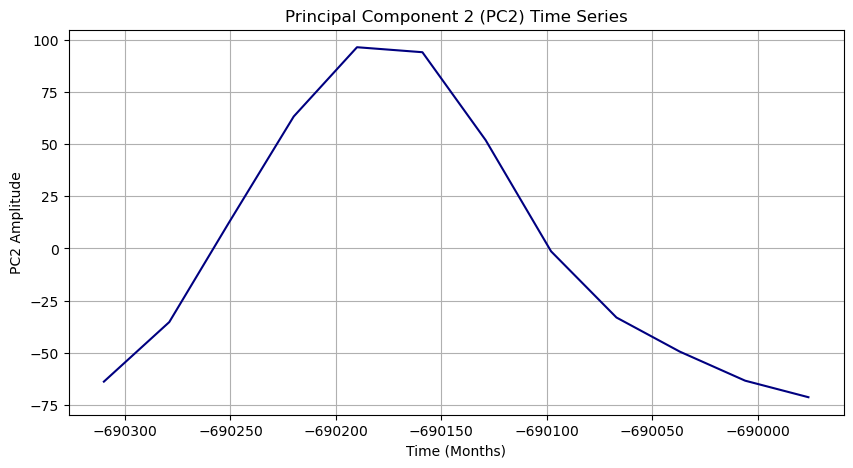

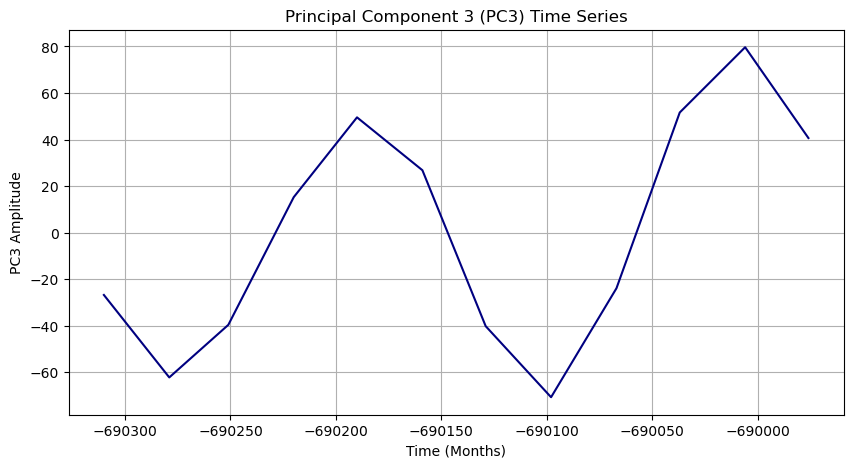

In [16]:
# Define a function for plotting PCs
def plot_pc(pc_series, pc_num):
    plt.figure(figsize=(10, 5))
    plt.plot(time, pc_series, color='navy')
    plt.xlabel("Time (Months)")
    plt.ylabel(f"PC{pc_num} Amplitude")
    plt.title(f"Principal Component {pc_num} (PC{pc_num}) Time Series")
    plt.grid()
    plt.show()

# Plot PC1, PC2, and PC3
plot_pc(pcs[:, 0], 1)
plot_pc(pcs[:, 1], 2)
plot_pc(pcs[:, 2], 3)


Time series of one grid cell- shows time series of seasonal vriability. Once this component is removed, then the next one should be ENSO

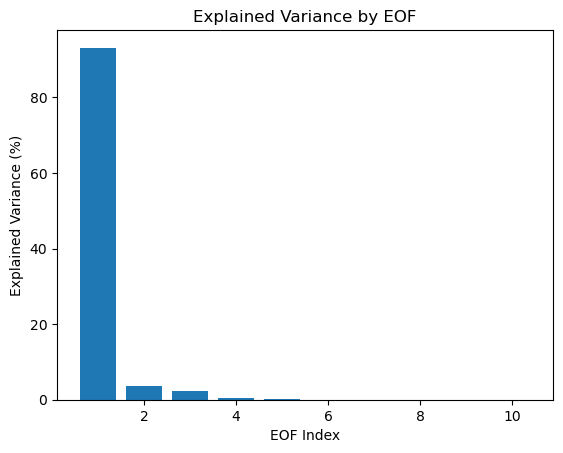

In [18]:
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100)
plt.xlabel('EOF Index')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by EOF')
plt.show()

Most of the variance is explained by the first EOF- seasonal variability